In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    root_mean_squared_error,
    r2_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import warnings
import pickle
from sklearn.model_selection import GridSearchCV

warnings.simplefilter(action="ignore", category=FutureWarning)

# **Step 1**

## OLS on PD

In [5]:
data = pd.read_excel("../dataproject2024.xlsx")
data.head()

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0


In [63]:
# Scale continuous variables to have a meaningful comparison of the coefficients
continuous_features = [
    "Job tenure",
    "Age",
    "Car price",
    "Funding amount",
    "Down payment",
    "Loan duration",
    "Monthly payment",
]
categorical_features = ["Down payment", "Credit event", "Married", "Homeowner"]

model = LinearRegression()

# Scale continuous features, include categorical features, drop the remaining columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_features),
        ("cat", "passthrough", categorical_features),
    ],
    remainder="drop",
)

# Fit a linear regression with
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regression", model)])


y = data["PD"]

# Split data between test and train
X_train, X_test, y_train, y_test = train_test_split(data, y)

# Fit the regressor
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Compute the RMSE
rmse = root_mean_squared_error(y_pred, y_test)
rmse

np.float64(0.15353914583891987)

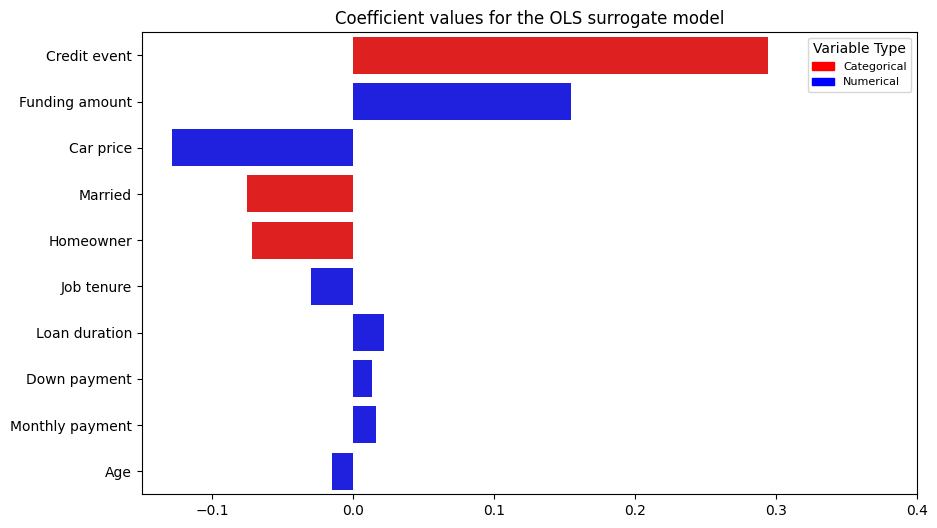

In [64]:
# Retrieve the coefficient values and feature names
coefficients = pipeline.named_steps["regression"].coef_
features = continuous_features + categorical_features

# Colorize the categorical features in red, numerical ones in blue
colors = ["blue" for i in continuous_features] + ["red" for i in categorical_features]

# Plot the coefficient values for each feature
plt.figure(figsize=(10, 6))

features_and_coeff = zip(features, coefficients, colors)
features_and_coeff_ranked = sorted(
    features_and_coeff, key=lambda x: abs(x[1]), reverse=True
)
ranked_features, ranked_coefficients, ranked_colors = zip(*features_and_coeff_ranked)

sns.barplot(
    x=ranked_coefficients,
    y=ranked_features,
    palette=ranked_colors,
    ci=None,
    legend=False,
)
plt.title("Coefficient values for the OLS surrogate model")
plt.xticks([-0.1, 0.0, 0.1, 0.2, 0.3, 0.4])

# Add colors to legend
red_patch = mpatches.Patch(color="red", label="Categorical")
blue_patch = mpatches.Patch(color="blue", label="Numerical")
plt.legend(handles=[red_patch, blue_patch], title="Variable Type", fontsize=8)

# Display the plot
plt.show()

## Logistic regression

In [22]:
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_excel("../dataproject2024.xlsx")
data.head()

NameError: name 'pd' is not defined

In [66]:
# We are going to fit a classifier on the y_hat predicted by the black box model
y = data["Pred_default (y_hat)"]

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, y)


# Scale continuous variables to have a meaningful comparison of the coefficients
continuous_features = [
    "Job tenure",
    "Age",
    "Car price",
    "Funding amount",
    "Down payment",
    "Loan duration",
    "Monthly payment",
]
categorical_features = ["Down payment", "Credit event", "Married", "Homeowner"]

model = LogisticRegression(penalty="l2")

# Scale continuous features, include categorical features, drop the remaining columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_features),
        ("cat", "passthrough", categorical_features),
    ],
    remainder="drop",
)

# Fit a linear regression with
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("log_regression", model)])

# Split data between test and train
X_train, X_test, y_train, y_test = train_test_split(data, y)

# Fit the regressor
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(
    f"""Our model has:
      - an accuracy on the test set of {accuracy} 
      - a balanced accuracy of {balanced_accuracy}
      - an auc of {auc}"""
)

Our model has:
      - an accuracy on the test set of 0.9068891280947255 
      - a balanced accuracy of 0.6408964424846954
      - an auc of 0.6408964424846955


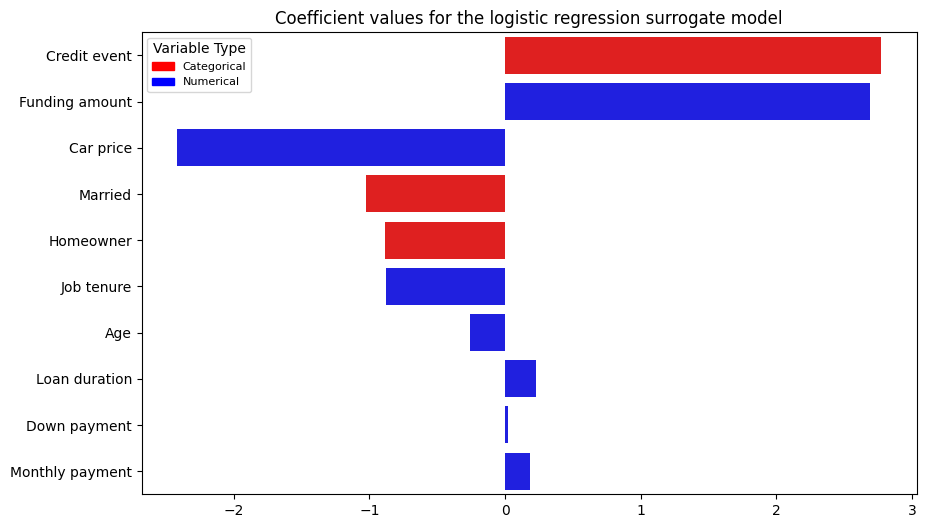

In [70]:
# Retrieve the coefficient values and feature names
coefficients = pipeline.named_steps["log_regression"].coef_.ravel()
features = continuous_features + categorical_features

# Colorize the categorical features in red, numerical ones in blue
colors = ["blue" for i in continuous_features] + ["red" for i in categorical_features]

# Plot the coefficient values for each feature
plt.figure(figsize=(10, 6))

features_and_coeff = zip(features, coefficients, colors)
features_and_coeff_ranked = sorted(
    features_and_coeff, key=lambda x: abs(x[1]), reverse=True
)
ranked_features, ranked_coefficients, ranked_colors = zip(*features_and_coeff_ranked)

sns.barplot(
    x=ranked_coefficients,
    y=ranked_features,
    palette=ranked_colors,
    ci=None,
    legend=False,
)
plt.title("Coefficient values for the logistic regression surrogate model")

# Add colors to legend
red_patch = mpatches.Patch(color="red", label="Categorical")
blue_patch = mpatches.Patch(color="blue", label="Numerical")
plt.legend(handles=[red_patch, blue_patch], title="Variable Type", fontsize=8)

# Display the plot
plt.show()

In [7]:
data.columns

Index(['ID', 'Job tenure', 'Age', 'Car price', 'Funding amount',
       'Down payment', 'Loan duration', 'Monthly payment', 'Credit event',
       'Married', 'Homeowner', 'Default (y)', 'Pred_default (y_hat)', 'PD',
       'Group'],
      dtype='object')

# **Step 2**

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import pandas as pd

# Sélection des features et de la target
X = data.drop(columns=["ID", "Pred_default (y_hat)", "PD", "Group", "Default (y)"])
y = data["Default (y)"]

# Encodage des variables catégorielles (si nécessaire)
X = pd.get_dummies(X, drop_first=True)

# Split des données en train et test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Créer le dataset LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Paramètres de LightGBM
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbosity": -1,
    "seed": 42,
}

# Entraîner le modèle LightGBM
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000)

# Prédictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Évaluation des performances
auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

AUC: 0.7357
F1 Score: 0.3510
Precision: 0.4323
Recall: 0.2954


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Supposons que y_pred_prob soit les probabilités prédites par le modèle LightGBM
# et que 'y_true' soit le vrai label (colonne 'Default (y)')
y_pred_prob = model.predict(X_test)
y_true = data["Default (y)"]  # Colonne vraie des labels (1 pour défaut, 0 sinon)

# Créer un DataFrame avec les probabilités et les vrais labels
df = pd.DataFrame({"probability": y_pred_prob, "true_label": y_true})

# Créer l'histogramme
plt.figure(figsize=(10, 6))

# Barres rouges pour les vrais labels égaux à 0 (pas de défaut)
sns.histplot(
    df[df["true_label"] == 0]["probability"],
    bins=20,
    color="red",
    label="Class 0 (No Default)",
    alpha=0.6,
)

# Barres vertes pour les vrais labels égaux à 1 (défaut)
sns.histplot(
    df[df["true_label"] == 1]["probability"],
    bins=20,
    color="green",
    label="Class 1 (Default)",
    alpha=0.6,
)

# Ajouter les labels et le titre
plt.xlabel("Probability Threshold")
plt.ylabel("Number of Cases")
plt.title("Histogram of Decision Probabilities by True Label")
plt.legend(loc="upper center")

# Afficher le graphique
plt.show()

ValueError: array length 1486 does not match index length 7430

In [23]:
X_test

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner
625,2,22,8900,8900,0,60,0.084828,0,0,0
2796,0,55,10400,9400,0,72,0.083889,0,0,0
101,1,40,15990,14990,0,60,0.127142,0,1,0
4767,5,43,19999,23233,0,72,0.153289,0,0,0
2018,1,26,11800,4298,1,24,0.115528,0,0,0
...,...,...,...,...,...,...,...,...,...,...
434,23,45,11850,9704,0,48,0.063984,0,1,1
751,22,60,10490,12019,0,84,0.065600,0,1,0
2183,22,41,8000,8000,0,72,0.029432,0,1,1
1872,4,55,11343,10343,0,36,0.174444,0,1,0


# **Step 3**

In [24]:
bb_model = pickle.load(open("../fitted_bb_model.pkl", "rb"))

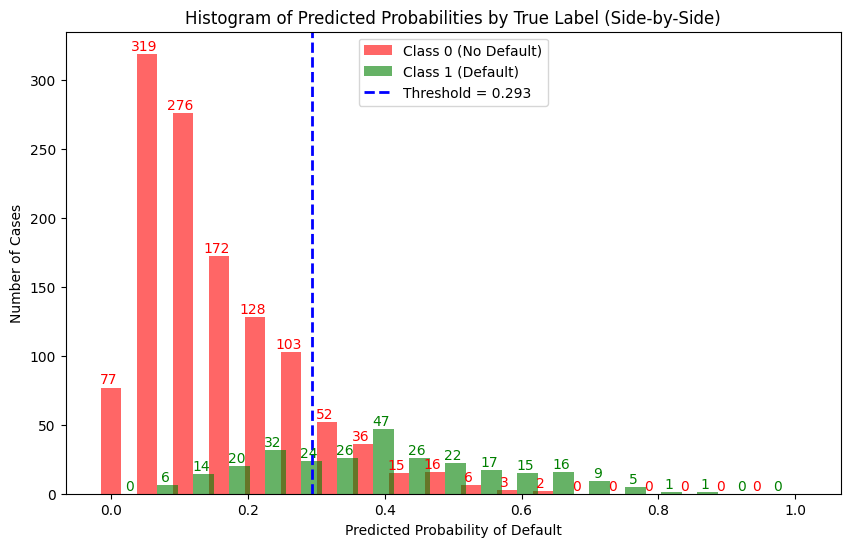

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Sélection des features et de la target
X = data.drop(columns=["ID", "Pred_default (y_hat)", "PD", "Group", "Default (y)"])
y = data["Default (y)"]

# Encodage des variables catégorielles si nécessaire
X = pd.get_dummies(X, drop_first=True)

# Split des données en train et test en conservant les index originaux
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, X.index, test_size=0.2, random_state=42
)

# Supposons que y_pred_prob sont les probabilités prédites par le modèle LightGBM
y_pred_prob = bb_model.predict_proba(X_test)[
    :, 1
]  # Probabilités de prédiction pour la classe 1 (faire défaut)

# Récupérer les vrais labels (colonne 'Default (y)') à partir des indices de test
y_true = data.loc[indices_test, "Default (y)"]

# Créer un DataFrame avec les probabilités prédites et les vrais labels
df = pd.DataFrame({"probability": y_pred_prob, "true_label": y_true.values})

# Créer deux ensembles de données : un pour la classe 0 (pas de défaut) et un pour la classe 1 (défaut)
class_0_probs = df[df["true_label"] == 0]["probability"]
class_1_probs = df[df["true_label"] == 1]["probability"]

# Définir le nombre de bins (intervalles)
bins = np.linspace(0, 1, 20)  # Crée 20 bins entre 0 et 1
bar_width = 0.03  # Largeur des barres

plt.figure(figsize=(10, 6))

# Décaler légèrement les barres pour éviter l'overlap en modifiant l'alignement des bins
offset = bar_width / 2  # Décalage à appliquer

# Histogramme pour la classe 0 (pas de défaut) en rouge
n_class_0, bins_class_0, patches_class_0 = plt.hist(
    class_0_probs,
    bins=bins - offset,
    alpha=0.6,
    color="red",
    label="Class 0 (No Default)",
    width=bar_width,
    align="mid",
)

# Histogramme pour la classe 1 (défaut) en vert
n_class_1, bins_class_1, patches_class_1 = plt.hist(
    class_1_probs,
    bins=bins + offset,
    alpha=0.6,
    color="green",
    label="Class 1 (Default)",
    width=bar_width,
    align="mid",
)

# Ajouter les étiquettes des valeurs au-dessus de chaque barre pour la classe 0
for i in range(len(patches_class_0)):
    plt.text(
        bins_class_0[i] + 1.5 * offset / 2,
        n_class_0[i] + 0.5,
        str(int(n_class_0[i])),
        ha="center",
        va="bottom",
        color="red",
    )

# Ajouter les étiquettes des valeurs au-dessus de chaque barre pour la classe 1
for i in range(len(patches_class_1)):
    plt.text(
        bins_class_1[i] + 1.5 * offset / 2,
        n_class_1[i] + 0.5,
        str(int(n_class_1[i])),
        ha="center",
        va="bottom",
        color="green",
    )

# Ajouter une ligne verticale à la probabilité seuil de 0.293
threshold = 0.293
plt.axvline(
    x=threshold,
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Threshold = {threshold}",
)

# Ajouter les labels et le titre
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Number of Cases")
plt.title("Histogram of Predicted Probabilities by True Label (Side-by-Side)")
plt.legend(loc="upper center")

# Afficher le graphique
plt.show()

In [47]:
data["Group"].value_counts()

Group
0    5131
1    2299
Name: count, dtype: int64

Step 9


In [50]:
import numpy as np
import pandas as pd
from scipy import stats


# Calculate the proportion of positive predictions (default) in each group
prop_A = data[data["Group"] == 0]["Pred_default (y_hat)"].mean()
prop_B = data[data["Group"] == 1]["Pred_default (y_hat)"].mean()

# Get the number of instances in each group
n_A = len(data[data["Group"] == 0])
n_B = len(data[data["Group"] == 1])

# Perform a two-proportion z-test
prop = (prop_A * n_A + prop_B * n_B) / (n_A + n_B)
z_stat = (prop_A - prop_B) / np.sqrt(prop * (1 - prop) * (1 / n_A + 1 / n_B))
p_value = stats.norm.sf(abs(z_stat)) * 2  # Two-tailed test

print(f"Proportion for Group 0: {prop_A:.4f}")
print(f"Proportion for Group 1: {prop_B:.4f}")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print(
        "There is a statistically significant difference in positive classification rates (default) between the two age groups."
    )
else:
    print(
        "No statistically significant difference in positive classification rates between the two age groups."
    )

Proportion for Group 0: 0.1645
Proportion for Group 1: 0.0083
Z-statistic: 19.4280
P-value: 0.0000
There is a statistically significant difference in positive classification rates (default) between the two age groups.


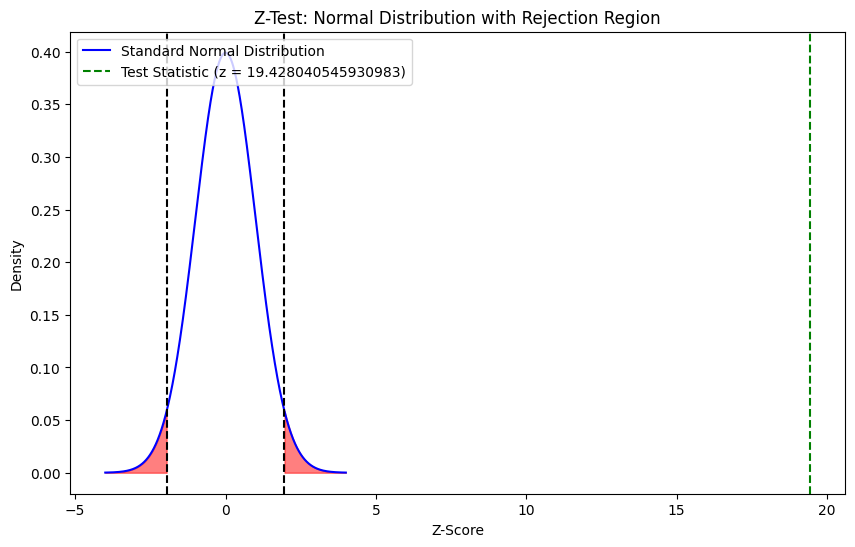

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Paramètres du test
alpha = 0.05  # Niveau de signification (par exemple 5%)

# Calculer la valeur critique pour une région de rejet bilatérale (pour un test à deux queues)
z_critical = stats.norm.ppf(1 - alpha / 2)  # Test bilatéral

# Créer une plage de valeurs pour la loi normale standard
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x, 0, 1)

# Tracer la loi normale standard
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Standard Normal Distribution", color="blue")

# Remplir la région de rejet à gauche (test bilatéral)
x_reject_left = np.linspace(-4, -z_critical, 100)
y_reject_left = stats.norm.pdf(x_reject_left, 0, 1)
plt.fill_between(x_reject_left, y_reject_left, color="red", alpha=0.5)

# Remplir la région de rejet à droite (test bilatéral)
x_reject_right = np.linspace(z_critical, 4, 100)
y_reject_right = stats.norm.pdf(x_reject_right, 0, 1)
plt.fill_between(x_reject_right, y_reject_right, color="red", alpha=0.5)

# Tracer la statistique de test sur le graphique
plt.axvline(
    x=z_stat, color="green", linestyle="--", label=f"Test Statistic (z = {z_stat})"
)

# Ajouter les lignes pour les valeurs critiques (région de rejet)
plt.axvline(x=-z_critical, color="black", linestyle="--")
plt.axvline(x=z_critical, color="black", linestyle="--")

# Ajouter des étiquettes et une légende
plt.title("Z-Test: Normal Distribution with Rejection Region")
plt.xlabel("Z-Score")
plt.ylabel("Density")
plt.legend(loc="upper left")

# Afficher le graphique
plt.show()